In [52]:
import os
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
DATA_DIR = '/Users/daodao/Documents/Columbia/Bayesian/Assignments/2/hw2/movies_csv/'

In [62]:
names = ['user_id', 'movie_id', 'rating']
df_train = pd.read_csv(os.path.join(DATA_DIR, 'ratings.csv'), names=names)
df_test = pd.read_csv(os.path.join(DATA_DIR, 'ratings_test.csv'), names=names)

In [4]:
with open(os.path.join(DATA_DIR, 'movies.txt'), 'r') as f:
    movies_names = f.read().splitlines()

# Change the data format

* Notice that users and movies index start from 1.

In [5]:
num_users = df_train.user_id.max()
num_movies = len(movies_names)
R = np.zeros([num_users, num_movies])
for idx in range(df_train.shape[0]):
    i, j, r = df_train.loc[idx, :]
    R[i - 1][j - 1] = r

# Implement EM algorithm

In [20]:
class EM_algorithm():
    def __init__(self, d=5, c=1, sigma_square=1):
        self.d = d
        self.c = c
        self.sigma_square = sigma_square
    
    def initialization(self, N, M):
        self.N = N
        self.M = M
        self.U = np.random.multivariate_normal(np.zeros(self.d), np.identity(self.d) * .1, N)
        self.V = np.random.multivariate_normal(np.zeros(self.d), np.identity(self.d) * .1, M)
    
    def train(self, R, T):
        sigma = self.sigma_square ** .5
        sigma_square = self.sigma_square
        c = self.c
        d = self.d
        U = self.U
        V = self.V
        E = np.zeros([self.N, self.M])
        history = []
        for t in range(T):
            # compute expectation
            # E-step
            UV = np.matmul(U, V.T)
            neg_UV_div_sigma = -UV / sigma
            E_pos = UV + sigma * norm.pdf(neg_UV_div_sigma) / (1 - norm.cdf(neg_UV_div_sigma))
            E_neg = UV + sigma * (-norm.pdf(neg_UV_div_sigma)) / norm.cdf(neg_UV_div_sigma)
            E[np.where(R > 0)] = E_pos[np.where(R > 0)]
            E[np.where(R < 0)] = E_neg[np.where(R < 0)]

            # maximize expectation
            # Update U
            for i in range(self.N):
                _U = np.matmul(V[np.where(R[i] != 0)].T, V[np.where(R[i] != 0)])
                U[i] = np.matmul(np.linalg.inv(np.identity(d) / c + _U / sigma_square),
                                 np.matmul(V[np.where(R[i] != 0)].T, E[i][np.where(R[i] != 0)] / sigma_square))
            
            # compute expectation
            # E-step
            UV = np.matmul(U, V.T)
            neg_UV_div_sigma = -UV / sigma
            E_pos = UV + sigma * norm.pdf(neg_UV_div_sigma) / (1 - norm.cdf(neg_UV_div_sigma))
            E_neg = UV + sigma * (-norm.pdf(neg_UV_div_sigma)) / norm.cdf(neg_UV_div_sigma)
            E[np.where(R > 0)] = E_pos[np.where(R > 0)]
            E[np.where(R < 0)] = E_neg[np.where(R < 0)]
            
            # maximize expectation
            # Update V
            for j in range(self.M):
                _V = np.matmul(U[np.where(R[:, j] != 0)].T, U[np.where(R[:, j] != 0)])
                V[j] = np.matmul(np.linalg.inv(np.identity(d) / c + _V / sigma_square),
                    np.matmul(U[np.where(R[:, j] != 0)].T, E[:, j][np.where(R[:, j] != 0)] / sigma_square))
            
            # calculate log of joint distribution
            UV = np.matmul(U, V.T)
            norm_cdf_UV_div_sigma = norm.cdf(UV / sigma)
            ln_p = np.sum(np.multiply((1 + R) / 2, np.log(norm_cdf_UV_div_sigma))[np.where(R != 0)]) \
                + np.sum(np.multiply((1 - R) / 2, np.log(1 - norm_cdf_UV_div_sigma))[np.where(R != 0)]) \
                - np.sum(U * U) / 2 / c \
                - np.sum(V * V) / 2 / c \
                - (self.N + self.M) * d / 2 * np.log(2 * np.pi * c)
            history.append(ln_p)
        return history

# Run the algorithm for 100 iterations

In [30]:
em_algo = EM_algorithm()
em_algo.initialization(num_users, num_movies)
ln_p = em_algo.train(R, 100)

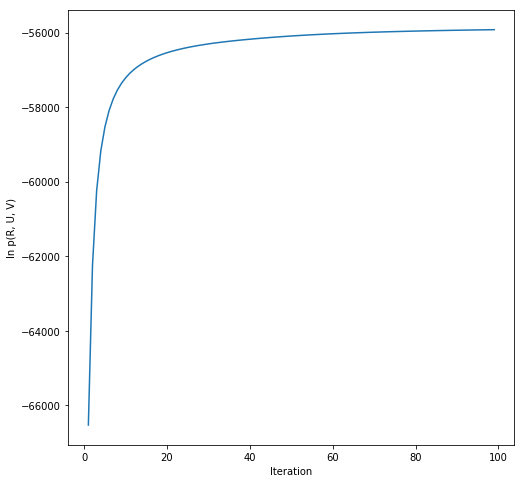

In [38]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.arange(1, 100), ln_p[1:])
ax.set(xlabel='Iteration', ylabel='ln p(R, U, V)')
plt.show()

# Using 5 different random starting points

In [31]:
ln_ps = []
for i in range(5):
    em_algo = EM_algorithm()
    em_algo.initialization(num_users, num_movies)
    ln_p = em_algo.train(R, 100)
    ln_ps.append(ln_p)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log


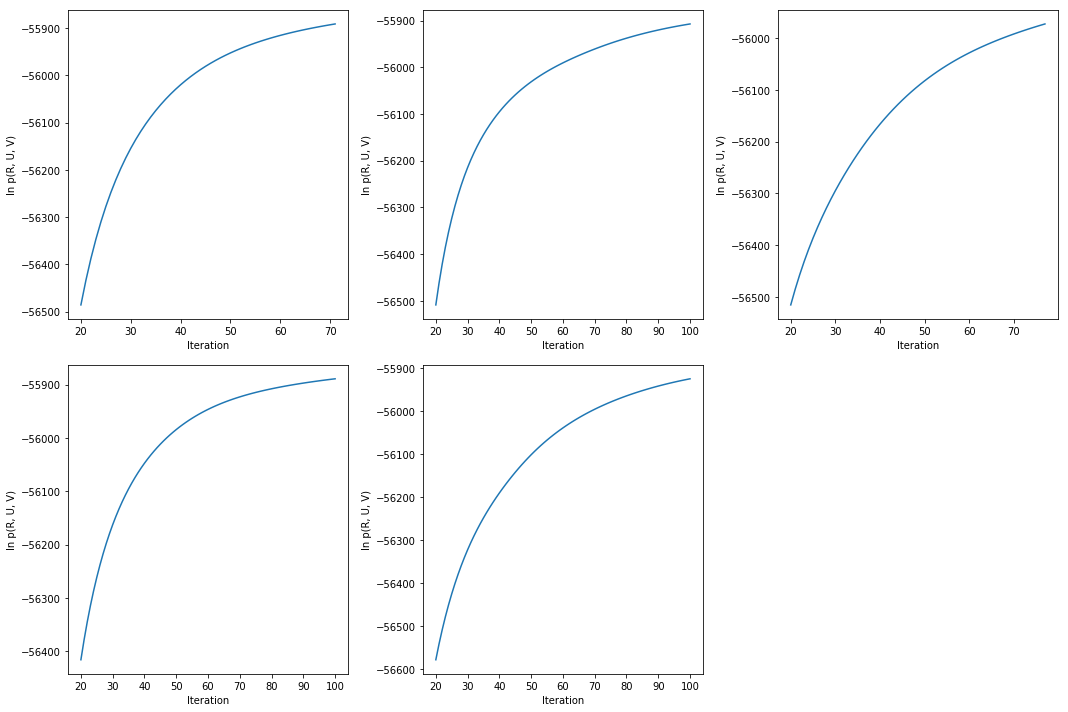

In [37]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(2):
    for j in range(3):
        n = i * 3 + j
        if n >= 5: break
        axs[i, j].plot(np.arange(20, 101), ln_ps[n][19:])
        axs[i, j].set_xlabel('Iteration')
        axs[i, j].set_ylabel('ln p(R, U, V)')
fig.tight_layout()
fig.delaxes(axs[1][2])
plt.show()

# Predict the values in the test set

In [63]:
df_test['rating_predict'] = 0
df_test['predict_prob'] = 0
sigma = 1

In [64]:
df_test['predict_prob'] = \
    df_test.apply(lambda row: \
        norm.cdf(np.dot(em_algo.U[row.user_id - 1], em_algo.V[row.movie_id - 1]) / sigma), axis=1)

In [65]:
df_test.rating_predict[df_test.predict_prob > .5] = 1
df_test.rating_predict[df_test.predict_prob <= .5] = -1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [67]:
confusion_matrix(df_test.rating, df_test.rating_predict)

array([[1416,  850],
       [ 611, 2123]])